In [152]:
# import library
import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import plotly as py
import math
import PAMI
from PAMI.extras.DF2DB import DenseFormatDF as db
from PAMI.extras.dbStats import TransactionalDatabase as tds
from PAMI.frequentPattern.basic import FPGrowth as alg
import umap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

In [3]:
#nltk.download('punkt_tab')

# 2. Data Preparation

In [4]:
# categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [5]:
# obtain the documents containing the categories provided
twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42)

In [6]:
# An example of what the subset contains
print("\n".join(twenty_train.data[0].split("\n")))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [7]:
# category of first 10 documents.
twenty_train.target[0:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2], dtype=int64)

In [8]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


# 3. Data Transformation

## 3.1 Converting Dictionary into Pandas Dataframe

In [9]:
# my functions
import helpers.data_mining_helpers as dmh

# construct dataframe from a list
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])

In [10]:
len(X)

2257

In [11]:
X[0:2]

,text
0,From: sd345@city.ac.uk (Michael Collier) Subje...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...


In [12]:
for t in X["text"][:2]:
    print(t)

From: sd345@city.ac.uk (Michael Collier) Subject: Converting images to HP LaserJet III? Nntp-Posting-Host: hampton Organization: The City University Lines: 14  Does anyone know of a good way (standard PC application/PD utility) to convert tif/img/tga files into LaserJet III format.  We would also like to do the same, converting to HPGL (HP plotter) files.  Please email any response.  Is this the correct group?  Thanks in advance.  Michael. --  Michael Collier (Programmer)                 The Computer Unit, Email: M.P.Collier@uk.ac.city                The City University, Tel: 071 477-8000 x3769                      London, Fax: 071 477-8565                            EC1V 0HB. 
From: ani@ms.uky.edu (Aniruddha B. Deglurkar) Subject: help: Splitting a trimming region along a mesh  Organization: University Of Kentucky, Dept. of Math Sciences Lines: 28    	Hi,  	I have a problem, I hope some of the 'gurus' can help me solve.  	Background of the problem: 	I have a rectangular mesh in the uv

### Adding Columns

In [13]:
# add category to the dataframe
X['category'] = twenty_train.target

In [14]:
# add category label also
X['category_name'] = X.category.apply(lambda t: dmh.format_labels(t, twenty_train))

In [15]:
X[0:10]

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med


## 3.2 Familiarizing yourself with the Data

In [16]:
# a simple query
X[:10][["text","category_name"]]

,text,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,sci.med


In [17]:
X[-10:]

,text,category,category_name
2247,From: daniels@math.ufl.edu (TV's Big Dealer) S...,3,soc.religion.christian
2248,"From: ""danny hawrysio"" <danny.hawrysio@canrem....",1,comp.graphics
2249,From: shellgate!llo@uu4.psi.com (Larry L. Over...,3,soc.religion.christian
2250,From: ingles@engin.umich.edu (Ray Ingles) Subj...,0,alt.atheism
2251,From: Mark-Tarbell@suite.com Subject: Amniocen...,2,sci.med
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med
2256,From: dyer@spdcc.com (Steve Dyer) Subject: Re:...,2,sci.med


In [18]:
# using loc (by label)
X.loc[:10, 'text']

0     From: sd345@city.ac.uk (Michael Collier) Subje...
1     From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...
2     From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...
3     From: s0612596@let.rug.nl (M.M. Zwart) Subject...
4     From: stanly@grok11.columbiasc.ncr.com (stanly...
5     From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...
6     From: jodfishe@silver.ucs.indiana.edu (joseph ...
7     From: aldridge@netcom.com (Jacquelin Aldridge)...
8     From: geb@cs.pitt.edu (Gordon Banks) Subject: ...
9     From: libman@hsc.usc.edu (Marlena Libman) Subj...
10    From: anasaz!karl@anasazi.com (Karl Dussik) Su...
Name: text, dtype: object

In [19]:
# using iloc (by position)
X.iloc[:10, 0]

0    From: sd345@city.ac.uk (Michael Collier) Subje...
1    From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...
2    From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...
3    From: s0612596@let.rug.nl (M.M. Zwart) Subject...
4    From: stanly@grok11.columbiasc.ncr.com (stanly...
5    From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...
6    From: jodfishe@silver.ucs.indiana.edu (joseph ...
7    From: aldridge@netcom.com (Jacquelin Aldridge)...
8    From: geb@cs.pitt.edu (Gordon Banks) Subject: ...
9    From: libman@hsc.usc.edu (Marlena Libman) Subj...
Name: text, dtype: object

## Exercise 2 take home

In [20]:
# df for tests
t = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])
t['category'] = twenty_train.target
t['category_name'] = t.category.apply(lambda t: dmh.format_labels(t, twenty_train))

#### Selecting random samples

In [21]:
# default
t.sample()

,text,category,category_name
2225,From: Desiree_Bradley@mindlink.bc.ca (Desiree ...,3,soc.religion.christian


In [22]:
# specific number of rows
t.sample(n=3)

,text,category,category_name
1081,From: Alla V. Kotenko <avk@lst.msk.su> Subjec...,2,sci.med
2170,From: naren@tekig1.PEN.TEK.COM (Naren Bala) Su...,0,alt.atheism
1137,From: dfitts@carson.u.washington.edu (Douglas ...,2,sci.med


#### The where() Method

In [23]:
s = t.loc[:10, 'category']

# return only the selected rows
s[s == 3]

2     3
3     3
4     3
5     3
6     3
10    3
Name: category, dtype: int64

In [24]:
# return a Series of the same shape as the original
s.where(s == 3)

0     NaN
1     NaN
2     3.0
3     3.0
4     3.0
5     3.0
6     3.0
7     NaN
8     NaN
9     NaN
10    3.0
Name: category, dtype: float64

In [25]:
t.where( t == 'sci.med')

,text,category,category_name
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2252,NaN,NaN,sci.med
2253,NaN,NaN,sci.med
2254,NaN,NaN,sci.med
2255,NaN,NaN,sci.med


In [26]:
# mask() is the inverse boolean operation of where.
t.mask(t == 'sci.med')

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
...,...,...,...
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,NaN
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,NaN
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,NaN
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,NaN


#### The query() Method

In [27]:
# selection using an expression
t.query('(category != 1) & (category_name != "soc.religion.christian")')

,text,category,category_name
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med
12,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,0,alt.atheism
13,Subject: So what is Maddi? From: madhaus@netco...,0,alt.atheism
...,...,...,...
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med


In [28]:
# in comparison operator
t.query('category in (1,2)')

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med
...,...,...,...
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med


In [29]:
t.query('category_name in ("comp.graphics","sci.med")')

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med
...,...,...,...
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med


In [30]:
# not in comparison operator
t.query('category not in (1,2)')

,text,category,category_name
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian
...,...,...,...
2237,From: datepper@phoenix.Princeton.EDU (David Aa...,0,alt.atheism
2246,From: lmvec@westminster.ac.uk (William Hargrea...,3,soc.religion.christian
2247,From: daniels@math.ufl.edu (TV's Big Dealer) S...,3,soc.religion.christian
2249,From: shellgate!llo@uu4.psi.com (Larry L. Over...,3,soc.religion.christian


In [31]:
t.query('category_name not in ("comp.graphics","sci.med")')

,text,category,category_name
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian
...,...,...,...
2237,From: datepper@phoenix.Princeton.EDU (David Aa...,0,alt.atheism
2246,From: lmvec@westminster.ac.uk (William Hargrea...,3,soc.religion.christian
2247,From: daniels@math.ufl.edu (TV's Big Dealer) S...,3,soc.religion.christian
2249,From: shellgate!llo@uu4.psi.com (Larry L. Over...,3,soc.religion.christian


# Data Mining using Pandas

## 4.1 Missing Values

In [32]:
# check missing values
X.isnull()

,text,category,category_name
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
2252,False,False,False
2253,False,False,False
2254,False,False,False
2255,False,False,False


In [33]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [34]:
dummy_series = pd.Series(["dummy_record", 1], index=["text", "category"])

In [35]:
dummy_series

text        dummy_record
category               1
dtype: object

In [36]:
dummy_series.to_frame().T
# .to_frame() -> Convert Series to DataFrame
# .T -> Transpose

,text,category
0,dummy_record,1


In [37]:
result_with_series = pd.concat([X, dummy_series.to_frame().T], ignore_index=True)

In [38]:
# check if the records was commited into result
len(result_with_series)

2258

In [39]:
result_with_series.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,1


In [40]:
# dummy record as dictionary format
dummy_dict = [{'text': 'dummy_record',
    'category': 1
}]

In [41]:
X = pd.concat([X, pd.DataFrame(dummy_dict)], ignore_index=True)

In [42]:
len(X)

2258

In [43]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,1


In [44]:
X.dropna(inplace=True)

In [45]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [46]:
len(X)

2257

## Exercise 5 take home

In [47]:
NA_dict = [{ 'id': 'A', 'missing_example': np.nan },
           { 'id': 'B' },
           { 'id': 'C', 'missing_example': 'NaN' },
           { 'id': 'D', 'missing_example': 'None' },
           { 'id': 'E', 'missing_example': None },
           { 'id': 'F', 'missing_example': '' }]

NA_df = pd.DataFrame(NA_dict, columns = ['id','missing_example'])
NA_df

,id,missing_example
0,A,NaN
1,B,NaN
2,C,NaN
3,D,None
4,E,None
5,F,


In [48]:
NA_df['missing_example'].isnull()

0     True
1     True
2    False
3    False
4     True
5    False
Name: missing_example, dtype: bool

## 4.2 Dealing with Duplicate Data

In [49]:
X.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2252    False
2253    False
2254    False
2255    False
2256    False
Length: 2257, dtype: bool

In [50]:
sum(X.duplicated())

0

In [51]:
sum(X.duplicated('text'))

0

In [52]:
dummy_duplicate_dict = [{
                        'text': 'dummy record',
                        'category': 1,
                        'category_name': "dummy category"
                        },
                        {
                        'text': 'dummy record',
                        'category': 1,
                        'category_name': "dummy category"
                        }]

In [53]:
X = pd.concat([X, pd.DataFrame(dummy_duplicate_dict)], ignore_index=True)

In [54]:
len(X)

2259

In [55]:
sum(X.duplicated())

1

In [56]:
X.drop_duplicates(keep=False, inplace=True) # inplace applies changes directly on our dataframe

In [57]:
len(X)

2257

# 5. Data Preprocessing

## 5.1 Sampling

In [58]:
X_sample = X.sample(n=1000) #random state

In [59]:
len(X_sample)

1000

In [60]:
X_sample[0:4]

,text,category,category_name
1987,"From: ""Robert Knowles"" <p00261@psilink.com> Su...",0,alt.atheism
2092,From: cormackj@access.digex.com (John Cormack)...,1,comp.graphics
767,From: besmith@uncc.edu (Brian E Smith) Subject...,1,comp.graphics
1509,From: ricky@watson.ibm.com (Rick Turner) Subje...,1,comp.graphics


## Exercise 6 take home

1. different size
2. X_sample data selected in random order

In [61]:
categories

['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

soc.religion.christian    599
sci.med                   594
comp.graphics             584
alt.atheism               480
Name: category_name, dtype: int64


<Axes: title={'center': 'Category distribution'}>

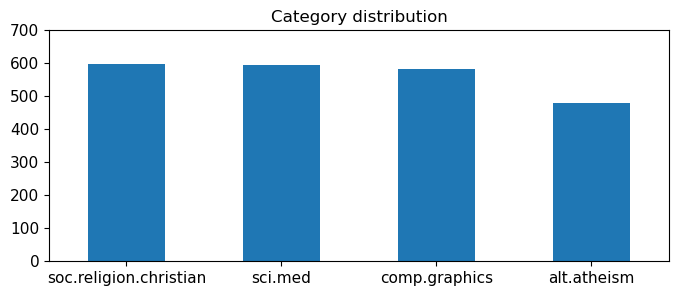

In [62]:
print(X.category_name.value_counts())
# plot barchart for X
X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 700],
                                    rot = 0, fontsize = 11, figsize = (8,3))

comp.graphics             268
soc.religion.christian    260
sci.med                   256
alt.atheism               216
Name: category_name, dtype: int64


<Axes: title={'center': 'Category distribution'}>

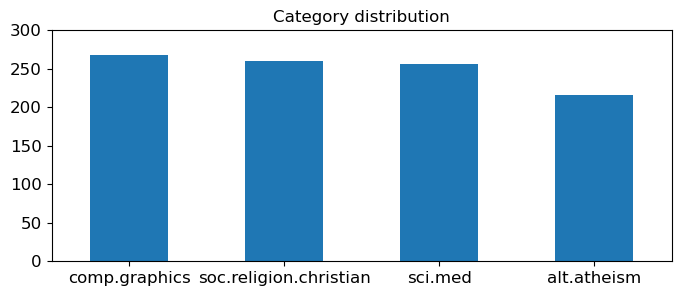

In [63]:
print(X_sample.category_name.value_counts())
# plot barchart for X_sample
X_sample.category_name.value_counts().plot(kind = 'bar',
                                           title = 'Category distribution',
                                           ylim = [0, 300],
                                           rot = 0, fontsize = 12, figsize = (8,3))

## Exercise 8 take home

<Axes: title={'center': 'Category distribution'}>

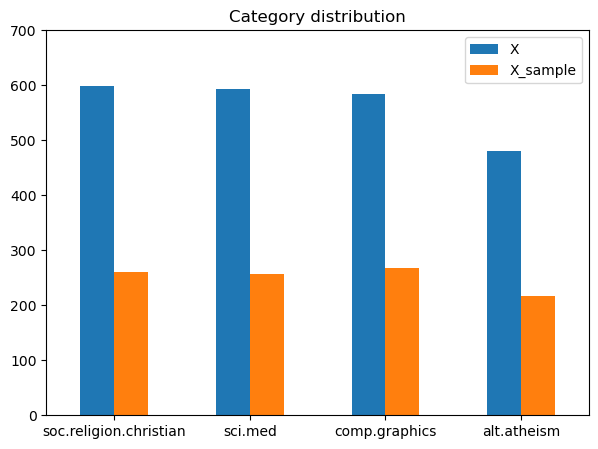

In [64]:
# concatenate 2 Series into a single DataFrame
cmp_df = pd.concat([X.category_name.value_counts(), X_sample.category_name.value_counts()], axis=1)

# set column names
cmp_df.columns = ['X', 'X_sample']

# plot
cmp_df.plot(kind = 'bar',
            title = 'Category distribution',
            ylim = [0, 700],
            rot = 0, fontsize = 10, figsize = (7,5))

## Feature Creation

In [65]:
# takes a like a minute or two to process
X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

In [66]:
X[0:4]["unigrams"]

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
1    [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....
2    [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...
3    [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...
Name: unigrams, dtype: object

In [67]:
X[0:4]

,text,category,category_name,unigrams
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics,"[From, :, sd345, @, city.ac.uk, (, Michael, Co..."
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics,"[From, :, ani, @, ms.uky.edu, (, Aniruddha, B...."
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian,"[From, :, djohnson, @, cs.ucsd.edu, (, Darin, ..."
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian,"[From, :, s0612596, @, let.rug.nl, (, M.M, ., ..."


In [68]:
list(X[0:1]['unigrams'])

[['From',
  ':',
  'sd345',
  '@',
  'city.ac.uk',
  '(',
  'Michael',
  'Collier',
  ')',
  'Subject',
  ':',
  'Converting',
  'images',
  'to',
  'HP',
  'LaserJet',
  'III',
  '?',
  'Nntp-Posting-Host',
  ':',
  'hampton',
  'Organization',
  ':',
  'The',
  'City',
  'University',
  'Lines',
  ':',
  '14',
  'Does',
  'anyone',
  'know',
  'of',
  'a',
  'good',
  'way',
  '(',
  'standard',
  'PC',
  'application/PD',
  'utility',
  ')',
  'to',
  'convert',
  'tif/img/tga',
  'files',
  'into',
  'LaserJet',
  'III',
  'format',
  '.',
  'We',
  'would',
  'also',
  'like',
  'to',
  'do',
  'the',
  'same',
  ',',
  'converting',
  'to',
  'HPGL',
  '(',
  'HP',
  'plotter',
  ')',
  'files',
  '.',
  'Please',
  'email',
  'any',
  'response',
  '.',
  'Is',
  'this',
  'the',
  'correct',
  'group',
  '?',
  'Thanks',
  'in',
  'advance',
  '.',
  'Michael',
  '.',
  '--',
  'Michael',
  'Collier',
  '(',
  'Programmer',
  ')',
  'The',
  'Computer',
  'Unit',
  ',',
  'Emai

## 5.3 Feature subset selection

In [69]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(X_counts[0])

  (0, 14887)	1
  (0, 29022)	1
  (0, 8696)	4
  (0, 4017)	2
  (0, 33256)	2
  (0, 21661)	3
  (0, 9031)	3
  (0, 31077)	1
  (0, 9805)	2
  (0, 17366)	1
  (0, 32493)	4
  (0, 16916)	2
  (0, 19780)	2
  (0, 17302)	2
  (0, 23122)	1
  (0, 25663)	1
  (0, 16881)	1
  (0, 16082)	1
  (0, 23915)	1
  (0, 32142)	5
  (0, 33597)	2
  (0, 20253)	1
  (0, 587)	1
  (0, 12051)	1
  (0, 5201)	1
  :	:
  (0, 25361)	1
  (0, 25337)	1
  (0, 12833)	2
  (0, 5195)	1
  (0, 27836)	1
  (0, 18474)	1
  (0, 32270)	1
  (0, 9932)	1
  (0, 15837)	1
  (0, 32135)	1
  (0, 17556)	1
  (0, 4378)	1
  (0, 26175)	1
  (0, 9338)	1
  (0, 33572)	1
  (0, 31915)	1
  (0, 177)	2
  (0, 2326)	2
  (0, 3062)	1
  (0, 35416)	1
  (0, 20459)	1
  (0, 14085)	1
  (0, 3166)	1
  (0, 12541)	1
  (0, 230)	1


In [70]:
count_vect.get_feature_names_out()[14887]

'from'

In [71]:
count_vect.get_feature_names_out()[29022]

'sd345'

In [72]:
count_vect.get_feature_names_out()[8696]

'city'

In [73]:
count_vect.get_feature_names_out()[4017]

'ac'

In [74]:
analyze = count_vect.build_analyzer()
analyze("I am craving for a hawaiian pizza right now")

# tokenization, remove stop words (e.g i, a, the), create n-gram (or unigram)

['am', 'craving', 'for', 'hawaiian', 'pizza', 'right', 'now']

In [75]:
# We can check the shape of this matrix by:
X_counts.shape

(2257, 35788)

In [76]:
# We can obtain the feature names of the vectorizer, i.e., the terms
# usually on the horizontal axis
count_vect.get_feature_names_out()[0:10]

array(['00', '000', '0000', '0000001200', '000005102000', '0001',
       '000100255pixel', '00014', '000406', '0007'], dtype=object)

In [77]:
X_counts.shape

(2257, 35788)

In [78]:
# we convert from sparse array to normal array
X_counts[0:5, 0:100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [79]:
count_vect.get_feature_names_out()[0:1]

array(['00'], dtype=object)

## Exercise 10 take home

In [80]:
# all words == 1 in the fifth record
count_vect.get_feature_names_out()[np.where(X_counts[0:5, 0:100].toarray()[4,] == 1)]

array(['00', '01'], dtype=object)

In [81]:
# second word == 1
count_vect.get_feature_names_out()[np.where(X_counts[0:5, 0:100].toarray()[4,] == 1)[0][1]]

'01'

In [82]:
# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:20]]

In [83]:
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]

In [84]:
plot_z = X_counts[0:20, 0:20].toarray() #X_counts[how many documents, how many terms]
plot_z

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

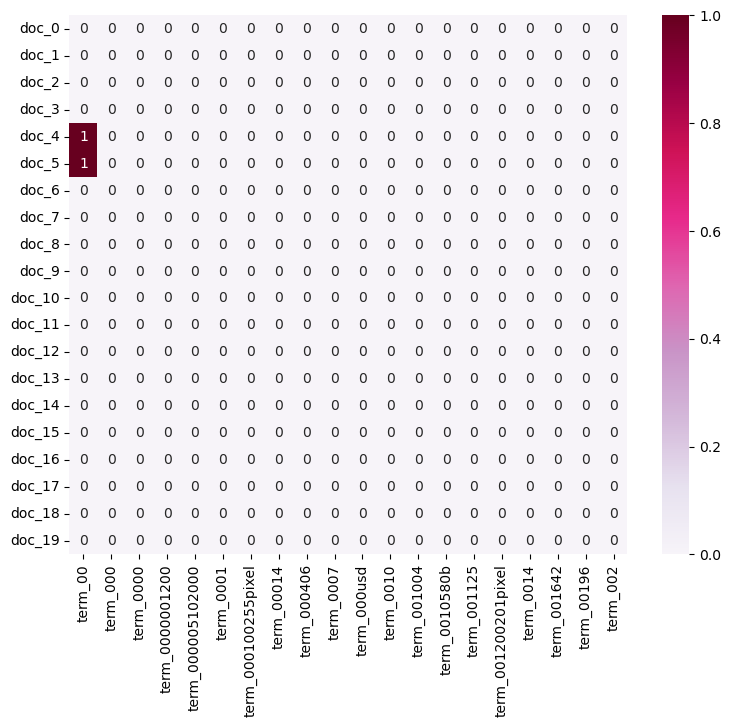

In [85]:
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                cmap="PuRd",
                vmin=0, vmax=1, annot=True)

## Exercise 11 take home

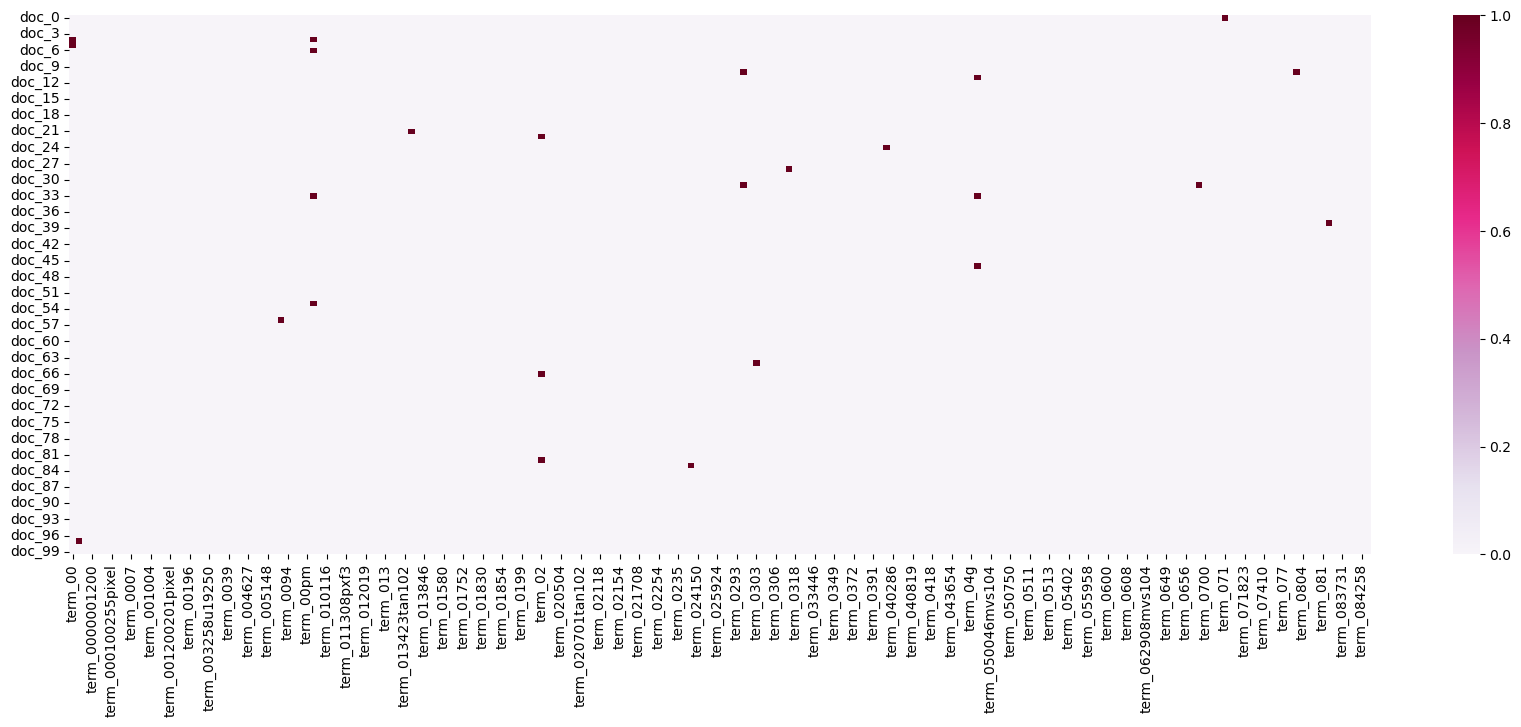

In [86]:
plot_xe = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:200]]
plot_ye = ["doc_"+ str(i) for i in list(X.index)[0:100]]
plot_ze = X_counts[0:100, 0:200].toarray()

df_todraw_e = pd.DataFrame(plot_ze, columns = plot_xe, index = plot_ye)

plt.subplots(figsize=(21, 7))

# if annot=True, write the data value in each cell
ax = sns.heatmap(df_todraw_e,
                cmap="PuRd",
                vmin=0, vmax=1, annot=False)

## 5.4 Attribute Transformation / Aggregation

In [87]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []
for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))


In [88]:
term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

In [89]:
term_frequencies[0] #sum of first term: 00

134

C:\Users\Qibing\AppData\Local\Temp\ipykernel_19220\1549152820.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);


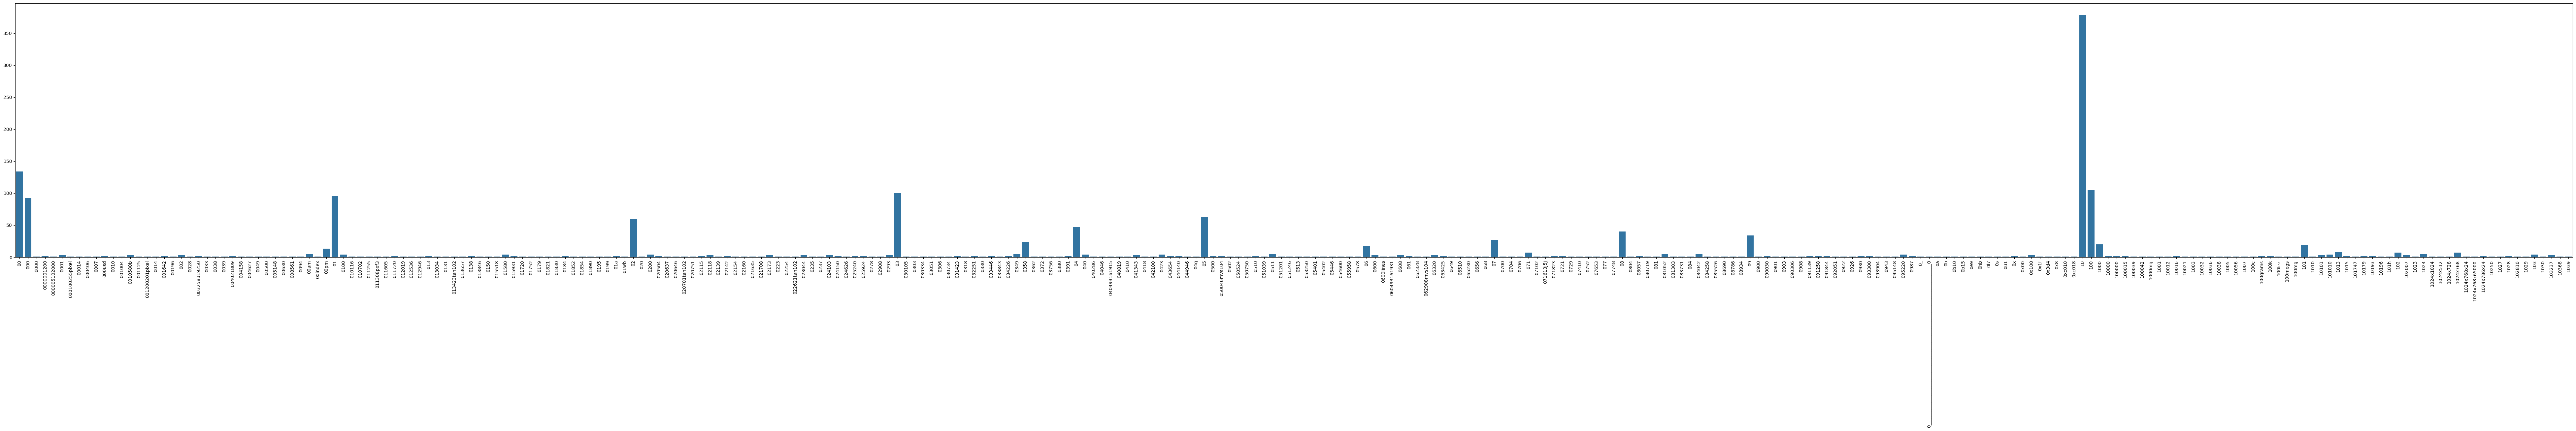

In [90]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
        y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

## Exercise 12 take home

## Exercise 13 take home

## Exercise 14 take home

In [91]:
term_frequencies_log = [math.log(i) for i in term_frequencies]

C:\Users\Qibing\AppData\Local\Temp\ipykernel_19220\2166548998.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);


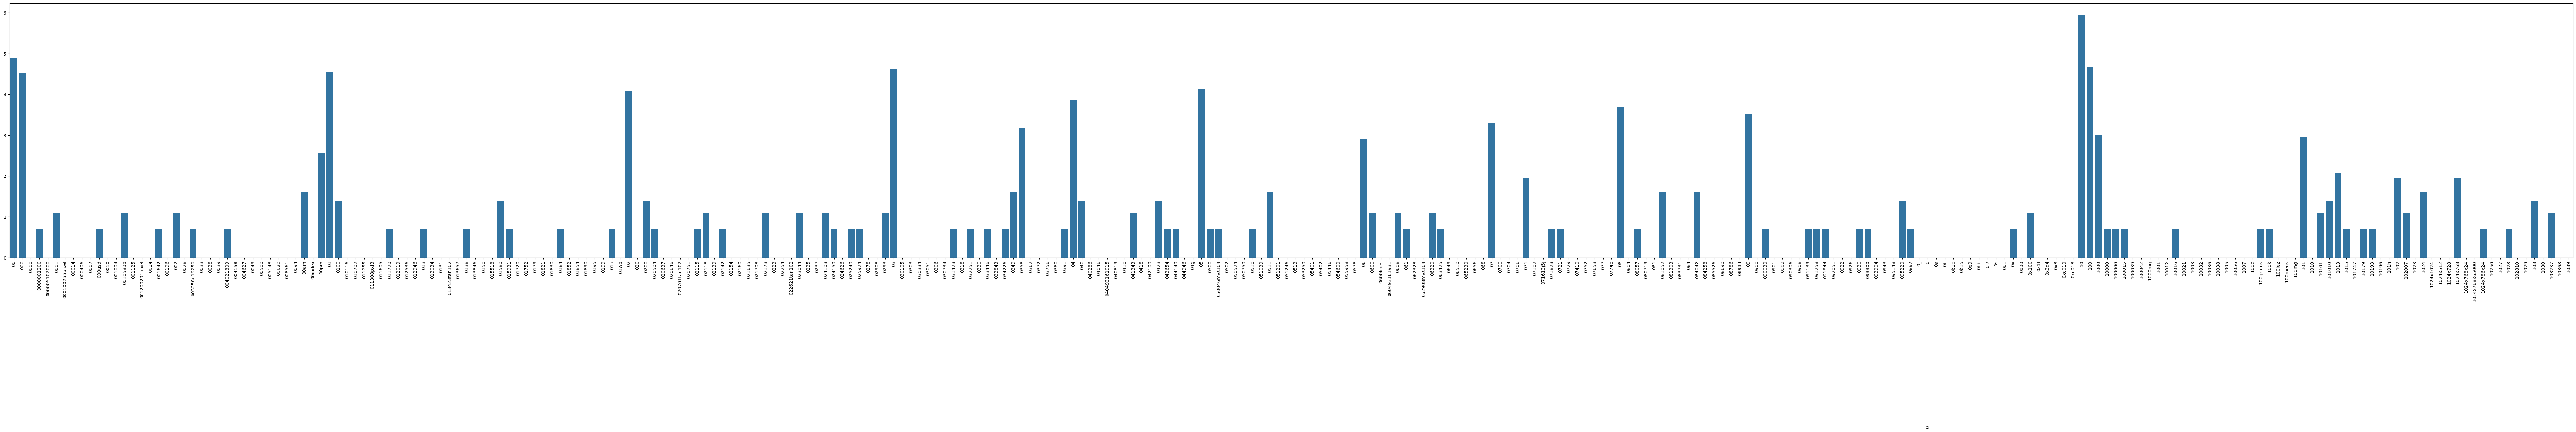

In [92]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

## Exercise 15 take home

## Finding frequent patterns

In [93]:
#Create separate DataFrames for each category
categories = X['category_name'].unique() # Get unique category labels
category_dfs = {} # Dictionary to store DataFrames for each category

for category in categories:
    # Filter the original DataFrame by category
    category_dfs[category] = X[X['category_name'] == category].copy()

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer() # Initialize the CountVectorizer
    X_counts = count_vect.fit_transform(df['text']) # Transform the text data into word counts

    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()

    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)

    return term_document_df


# Create term-document frequency DataFrames for each category
term_document_dfs = {} # Dictionary to store term-document DataFrames for each category

for category in categories:
    term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [94]:
# Display the filtered DataFrame for one of the categories, feel free to change the number in the vector
category_number=0 #You can change it from 0 to 3
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category comp.graphics:


,00,000,000005102000,000100255pixel,0007,000usd,0010580b,001200201pixel,00196,002,...,zorn,zrz,zsoft,zt,zug,zurich,zvi,zyeh,zyxel,ªl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


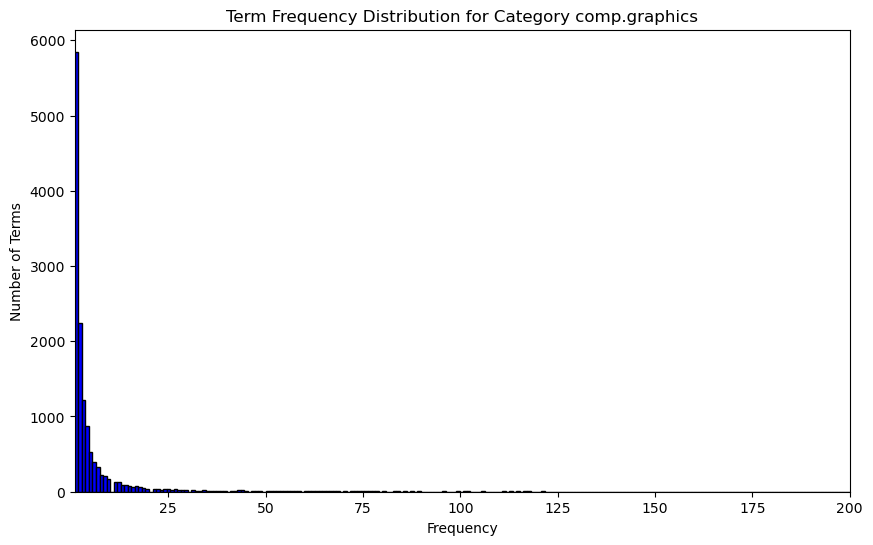

In [95]:
# Sum over all documents to get total frequency for each word
category_number=0 #You can change it from 0 to 3
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Visualize the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=5000, color='blue', edgecolor='black')
plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 200)
plt.show()

In [96]:
category_number=3 #You can change it from 0 to 3
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Sort the term frequencies in descending order
sorted_indices = np.argsort(word_counts) # Get indices of sorted frequencies
sorted_counts = np.sort(word_counts)[::-1] # Sort frequencies in descending order

# Calculate the index corresponding to the top 5% most frequent terms
total_terms = len(sorted_counts)
top_5_percent_index = int(0.05 * total_terms)

# Get the indices of the top 5% most frequent terms
top_5_percent_indices = sorted_indices[:top_5_percent_index]

# Filter terms that belong to the top 5% based on their rank
filtered_words = [count_vect.get_feature_names_out()[i] for i in top_5_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in top 5%: {top_5_percent_index}")
print(f"Filtered terms: {filtered_words}")

Category: alt.atheism
Number of terms in top 5%: 598
Filtered terms: ['djohnson', 'charset', 'a2x', 'a2623', 'a16pd', 'a137490', 'chassis', 'a1', 'a000', '_yourself_', '_your_', '_you_', 'chastisement', 'chastity', 'chat', '_why', '_whole_', '_whole', 'a66', 'a7d56e52', 'charlottesville', 'a7f81fd2f801023c', 'aantal_snijpunten', 'characterizes', 'aanerud', 'characterizing', 'aah', 'charge', 'aacc', 'aaai', '_which', 'aaaa', 'aa888', 'charges', 'aa17104', 'aa09923', 'charging', 'chariot', 'charism', 'charismatic', 'aaa', 'characteristics', 'chatting', '_washington', '_the', '_that_', 'chehey', 'cheinan', '_talk_', 'chelsea', 'chem', '_synners_', '_symbol_', 'chemical', 'chemicals', '_steelcollar', '_speed_', 'chemist', '_something_', '_someone', 'chemlab', 'cheeses', 'cheese', 'cheering', 'cheerful', 'chay', '_want_', 'cheat', '_used_', '_us_', '_until_', 'cheated', 'checker', 'chavey', 'checklist', 'checkman', 'checkmate', '_this_', 'checks', 'cheek', '_them_', '_their_', '_the_wholly_

In [97]:
category_number=3 #You can change it from 0 to 3
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Sort the term frequencies in ascending order and get sorted indices
sorted_indices = np.argsort(word_counts) # Get indices of sorted frequencies
sorted_counts = word_counts[sorted_indices] # Sort frequencies

# Calculate the index corresponding to the bottom 1% least frequent terms
total_terms = len(sorted_counts)
bottom_1_percent_index = int(0.01 * total_terms)

# Get the indices of the bottom 1% least frequent terms
bottom_1_percent_indices = sorted_indices[:bottom_1_percent_index]

# Filter terms that belong to the bottom 1% based on their rank
filtered_words = [count_vect.get_feature_names_out()[i] for i in bottom_1_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in bottom 1%: {bottom_1_percent_index}")
print(f"Filtered terms: {filtered_words}")

Category: alt.atheism
Number of terms in bottom 1%: 119
Filtered terms: ['djohnson', 'charset', 'a2x', 'a2623', 'a16pd', 'a137490', 'chassis', 'a1', 'a000', '_yourself_', '_your_', '_you_', 'chastisement', 'chastity', 'chat', '_why', '_whole_', '_whole', 'a66', 'a7d56e52', 'charlottesville', 'a7f81fd2f801023c', 'aantal_snijpunten', 'characterizes', 'aanerud', 'characterizing', 'aah', 'charge', 'aacc', 'aaai', '_which', 'aaaa', 'aa888', 'charges', 'aa17104', 'aa09923', 'charging', 'chariot', 'charism', 'charismatic', 'aaa', 'characteristics', 'chatting', '_washington', '_the', '_that_', 'chehey', 'cheinan', '_talk_', 'chelsea', 'chem', '_synners_', '_symbol_', 'chemical', 'chemicals', '_steelcollar', '_speed_', 'chemist', '_something_', '_someone', 'chemlab', 'cheeses', 'cheese', 'cheering', 'cheerful', 'chay', '_want_', 'cheat', '_used_', '_us_', '_until_', 'cheated', 'checker', 'chavey', 'checklist', 'checkman', 'checkmate', '_this_', 'checks', 'cheek', '_them_', '_their_', '_the_whol

In [98]:
category_number=0 #You can change it from 0 to 3

# Filter the bottom 1% and top 5% words based on their sum across all documents
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    # Calculate the sum of each word across all documents
    word_sums = term_document_df.sum(axis=0)

    # Sort the words by their total sum
    sorted_words = word_sums.sort_values()
    
    # Calculate the number of words to remove
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    # Get the words to remove from the top 5% and bottom 1%
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index

    # Return the DataFrame without the filtered words
    return term_document_df.drop(columns=words_to_remove)


# Apply the filtering function to each category
filtered_term_document_dfs = {}

for category in categories:
    filtered_term_document_dfs[category] = filter_top_bottom_words_by_sum(term_document_dfs[category])
    
term_document_dfs=filtered_term_document_dfs
# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category comp.graphics:


,000,000005102000,000100255pixel,0007,000usd,0010580b,001200201pixel,00196,002,0028,...,zorn,zrz,zsoft,zt,zug,zurich,zvi,zyeh,zyxel,ªl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exercise 16: take home

Review the words that were filtered in each category and comment about the differences and similarities that you can see.

#### The next part of the code will take a couple of minutes to execute, for simplicity I already shared the resulting files from it, to continue onwards

just use resulting files from git

Database size (total no of transactions) : 584
Number of items : 12932
Minimum Transaction Size : 4
Average Transaction Size : 56.41267123287671
Maximum Transaction Size : 2063
Standard Deviation Transaction Size : 152.52064505570053
Variance in Transaction Sizes : 23302.448621325693
Sparsity : 0.995637745806304


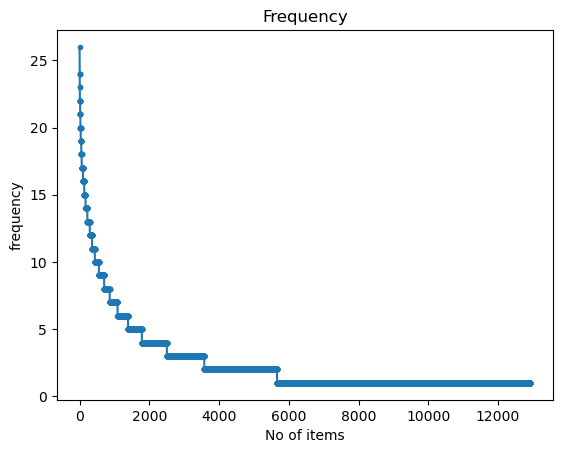

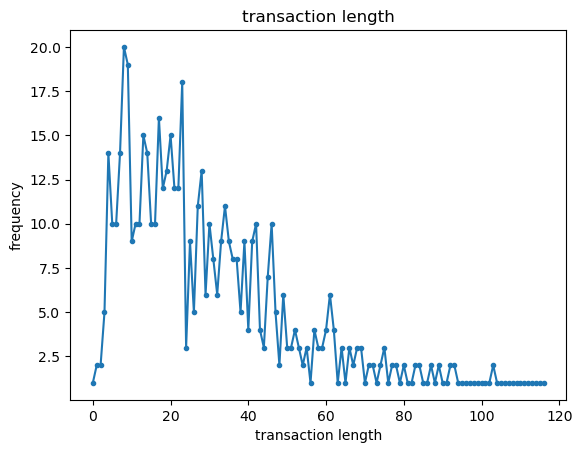

In [100]:
obj = tds.TransactionalDatabase('td_freq_db_comp_graphics.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 594
Number of items : 15283
Minimum Transaction Size : 9
Average Transaction Size : 74.55892255892256
Maximum Transaction Size : 1070
Standard Deviation Transaction Size : 115.43440452043433
Variance in Transaction Sizes : 13347.572407606136
Sparsity : 0.9951214471923757


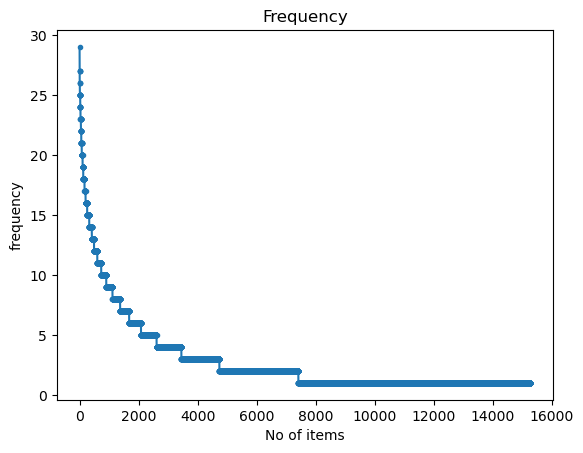

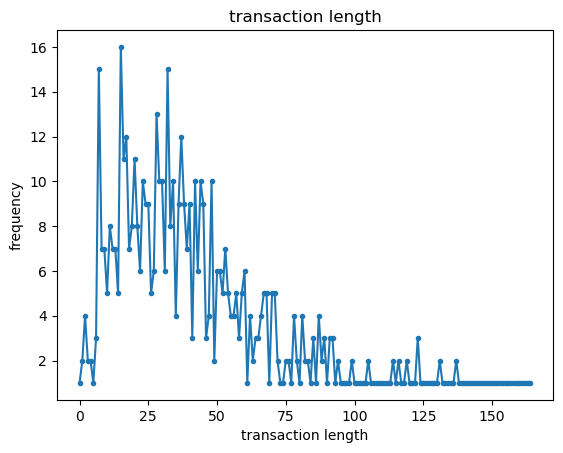

In [101]:
obj = tds.TransactionalDatabase('td_freq_db_sci_med.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 480
Number of items : 11250
Minimum Transaction Size : 5
Average Transaction Size : 75.59791666666666
Maximum Transaction Size : 1395
Standard Deviation Transaction Size : 105.33869380396925
Variance in Transaction Sizes : 11119.405841162144
Sparsity : 0.9932801851851852


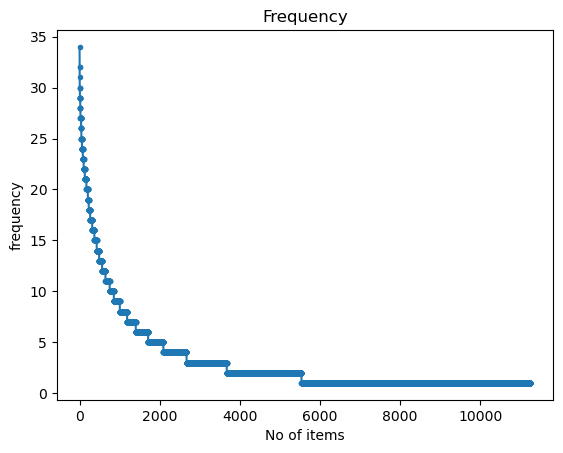

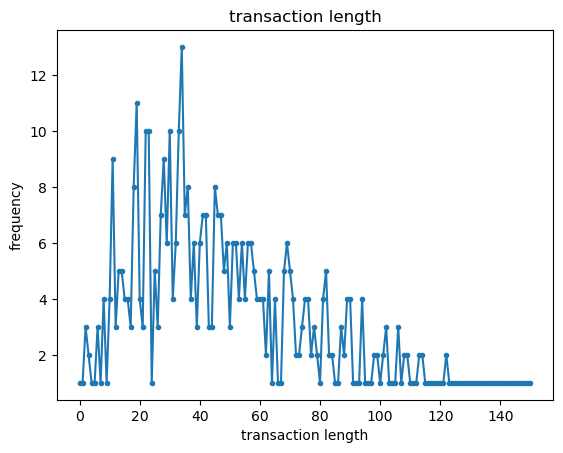

In [102]:
obj = tds.TransactionalDatabase('td_freq_db_alt_atheism.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [103]:
minSup=9
obj1 = alg.FPGrowth(iFile='td_freq_db_sci_med.csv', minSup=minSup)
obj1.mine()
frequentPatternsDF_sci_med= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_sci_med))) #print the total number of patterns
print('Runtime: ' + str(obj1.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 10000
Runtime: 0.38403916358947754


In [104]:
obj1.save('freq_patterns_sci_med_minSup9.txt') #save the patterns
frequentPatternsDF_sci_med

,Patterns,Support
0,leave,9
1,swell,9
2,color,9
3,confused,9
4,learning,9
...,...,...
9995,means,27
9996,haven,27
9997,happen,27
9998,originator,27


In [105]:
minSup=9
obj2 = alg.FPGrowth(iFile='td_freq_db_alt_atheism.csv', minSup=minSup)
obj2.mine()
frequentPatternsDF_alt_atheism= obj2.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_alt_atheism))) #print the total number of patterns
print('Runtime: ' + str(obj2.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 4676
Runtime: 0.17911529541015625


In [106]:
obj2.save('freq_patterns_alt_atheism_minSup9.txt') #save the patterns
frequentPatternsDF_alt_atheism

,Patterns,Support
0,choices,9
1,corp,9
2,hausmann,9
3,hausmann maddi,9
4,kids,9
...,...,...
4671,date,31
4672,date gmt,19
4673,stay,32
4674,snm6394,32


In [107]:
minSup=9
obj3 = alg.FPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=minSup)
obj3.mine()
frequentPatternsDF_comp_graphics= obj3.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_comp_graphics))) #print the total number of patterns
print('Runtime: ' + str(obj3.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 33574
Runtime: 0.12060141563415527


In [108]:
obj3.save('freq_patterns_comp_graphics_minSup9.txt') #save the patterns
frequentPatternsDF_comp_graphics

,Patterns,Support
0,individual,9
1,certain,9
2,hall,9
3,mike,9
4,vr,9
...,...,...
33569,life,24
33570,ideas,24
33571,feel,24
33572,tried,24


In [109]:
minSup=9
obj4 = alg.FPGrowth(iFile='td_freq_db_soc_religion_christian.csv', minSup=minSup)
obj4.mine()
frequentPatternsDF_soc_religion_christian= obj4.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_soc_religion_christian))) #print the total number of patterns
print('Runtime: ' + str(obj4.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 11213
Runtime: 0.2468113899230957


In [110]:
obj4.save('freq_patterns_soc_religion_minSup9.txt') #save the patterns
frequentPatternsDF_soc_religion_christian

,Patterns,Support
0,latest,9
1,san,9
2,seven,9
3,schools,9
4,chose,9
...,...,...
11208,34,33
11209,institute,33
11210,ways,33
11211,oh,34


In [111]:
#We group together all of the dataframes related to our found patterns
dfs = [frequentPatternsDF_sci_med, frequentPatternsDF_soc_religion_christian, frequentPatternsDF_comp_graphics, frequentPatternsDF_alt_atheism]

# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1
            
# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(df) for df in dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)
    
# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")

                        Patterns  Support
19911                        gov       33
19912                  institute       33
57158                    snm6394       32
19910                       form       31
57156                    deleted       30
...                          ...      ...
54045  axes funds motss matching        9
54044   boy funds motss matching        9
54043    boy axes motss matching        9
54042    et funds motss matching        9
0                          swell        9

[57159 rows x 2 columns]
Number of patterns discarded: 2304


In [112]:
# Convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(X['text']) # X['text'] contains your text data
terms = count_vect.get_feature_names_out() # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
X['tokenized_text'] = X['text'].str.split().apply(set)

# Initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split()) # Tokenize pattern into words
    pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)

# Concatenate the original TDM and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,soc princeton funds motss matching,soc princeton boy motss matching,et axes motss matching,soc princeton et motss matching,soc princeton al motss matching,axes funds motss matching,boy funds motss matching,boy axes motss matching,et funds motss matching,swell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exercise 17 take home

In [113]:
from PAMI.frequentPattern.maximal import MaxFPGrowth as mfpg
from PAMI.frequentPattern.topk import FAE as fae

In [114]:
for i in range(3, 12, 3):
    print('__________________________________________________________________________________')
    obj = mfpg.MaxFPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=i)
    obj.mine()
    frequentPatternsDF_comp_graphics = obj.getPatternsAsDataFrame()
    print('minSup: ', i)
    print('Total No of patterns: ', str(len(frequentPatternsDF_comp_graphics)))
    print('Runtime: ', str(obj.getRuntime()))
    print(frequentPatternsDF_comp_graphics)


__________________________________________________________________________________
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
minSup:  3
Total No of patterns:  6872
Runtime:  23.793264865875244
                                               Patterns  Support
0     due bytes responsible 000 opinion 640x480 rob ...        3
1                                                  bag         3
2                                          garbo uwasa         3
3             wrong 200 responsible 000 umn 480 640 tc         3
4                                responsible 000 essex         3
...                                                 ...      ...
6867                                    didn wondering         3
6868                             feel wrong personally         3
6869                                     wrong correct         3
6870                                      life correct         3
6871                                        maybe 

In [115]:
for i in range(500, 2000, 500):
    print('_______________________________________________________________________')
    obj = fae.FAE(iFile='td_freq_db_comp_graphics.csv', k=i)
    obj.mine()
    frequentPatternsDF_comp_graphics = obj.getPatternsAsDataFrame()
    print('FAE Top-K with k: ', i)
    print('Total No of patterns: ', str(len(frequentPatternsDF_comp_graphics)))
    print('Runtime: ', str(obj.getRuntime()))
    print(frequentPatternsDF_comp_graphics)


_______________________________________________________________________
 TopK frequent patterns were successfully generated using FAE algorithm.
FAE Top-K with k:  500
Total No of patterns:  500
Runtime:  0.9161641597747803
                                              Patterns  Support
0                                                maybe       26
1                                                 life       24
2                                                ideas       24
3                                                 feel       24
4                                                tried       24
..                                                 ...      ...
495  awful posts curious concerning proposed learn ...       12
496  posts curious concerning proposed learn forum ...       12
497  convenience posts curious concerning proposed ...       12
498  posts curious concerning proposed learn forum ...       12
499  posts curious concerning proposed learn forum ...       12

[500 ro

## 5.5 Dimensionality Reduction

In [116]:
#This might take a couple of minutes to execute
# Apply PCA, t-SNE, and UMAP to the data
X_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
X_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
X_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

In [117]:
X_pca_tdm.shape

(2257, 2)

In [118]:
X_tsne_tdm.shape

(2257, 2)

In [119]:
X_umap_tdm.shape

(2257, 2)

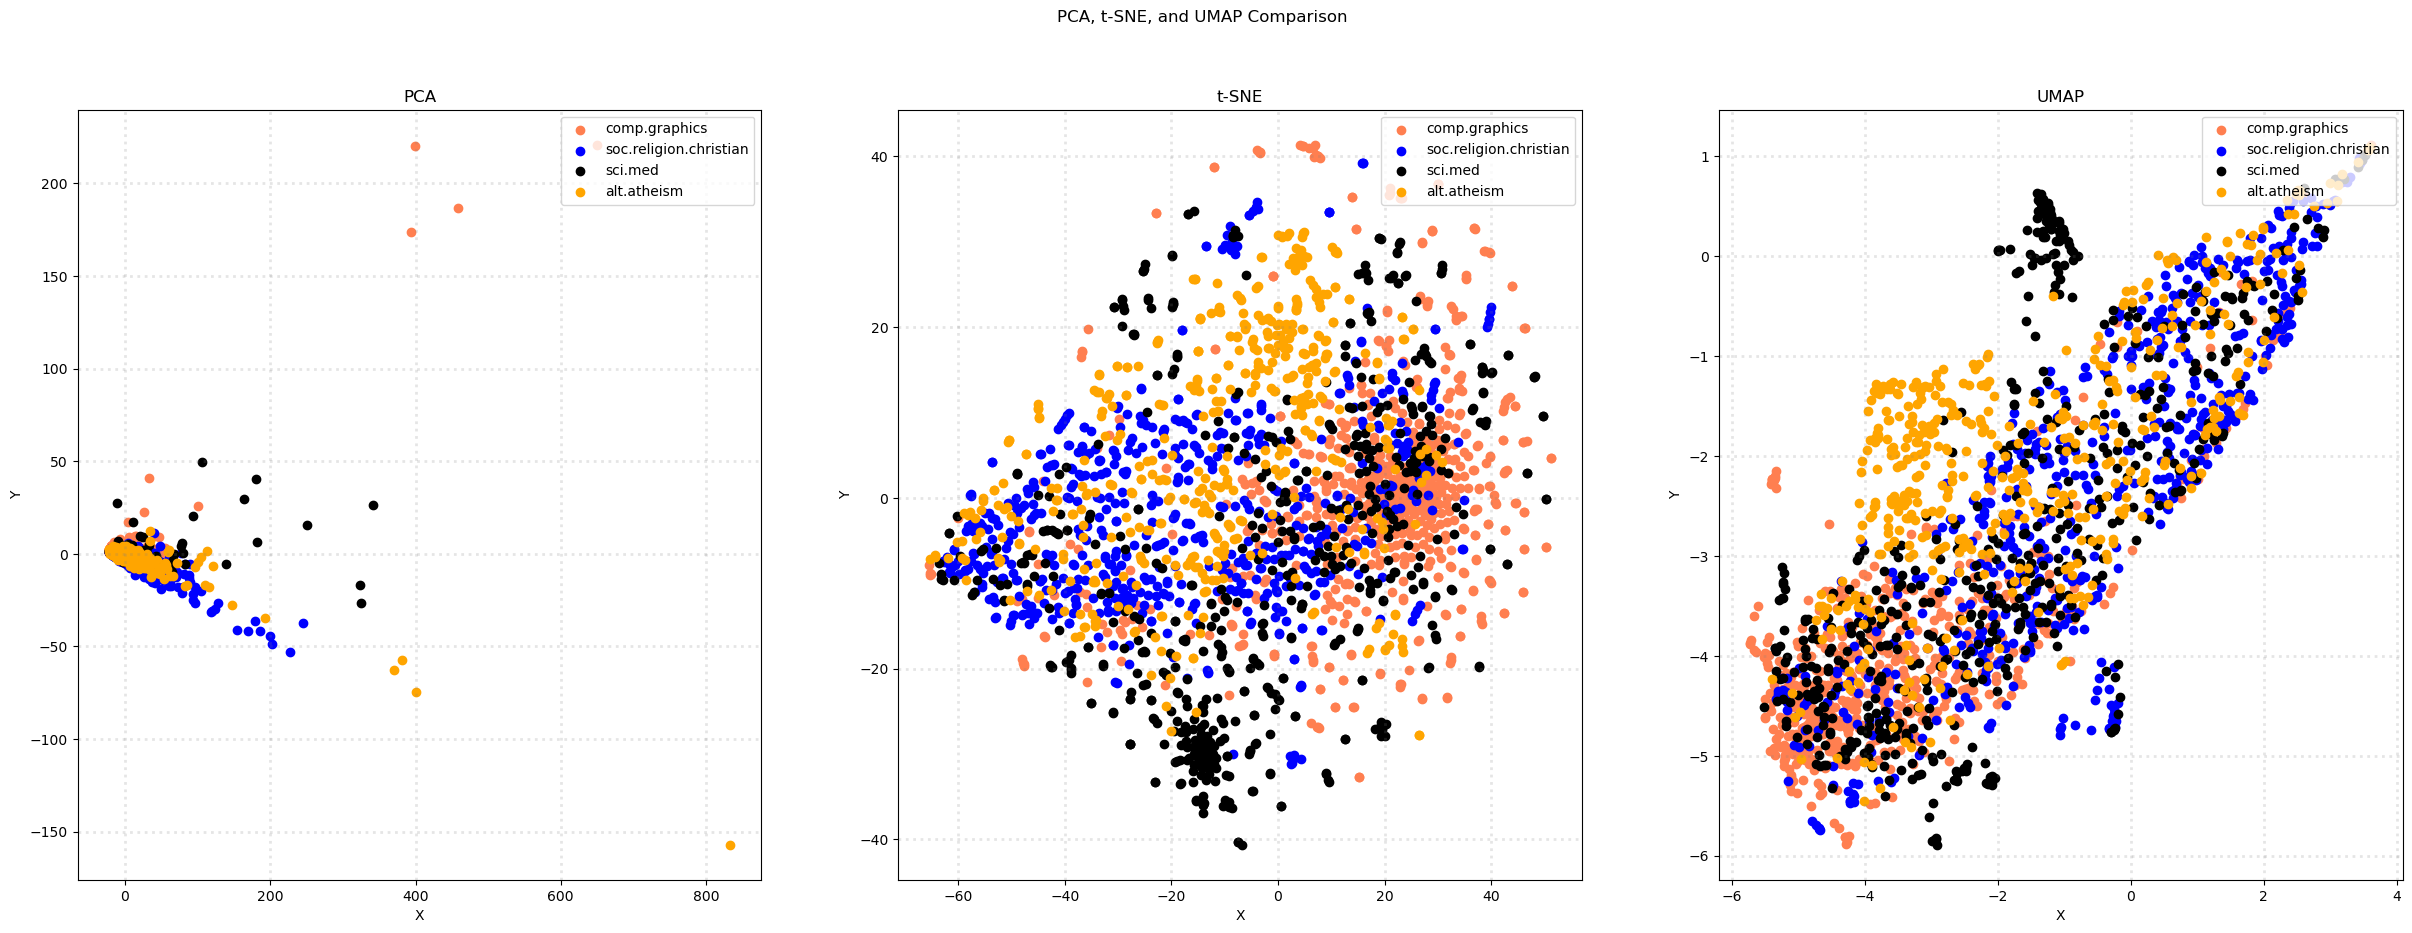

In [120]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique()

fig, axes = plt.subplots(1, 3, figsize=(30, 10)) # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)

    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
    
# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_tdm, 'PCA')
plot_scatter(axes[1], X_tsne_tdm, 't-SNE')
plot_scatter(axes[2], X_umap_tdm, 'UMAP')

plt.show()

In [121]:
#This might take a couple of minutes to execute
#Applying dimensionality reduction with both the document-term frequency data and the pattern derived data
# Apply PCA, t-SNE, and UMAP to the data
X_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

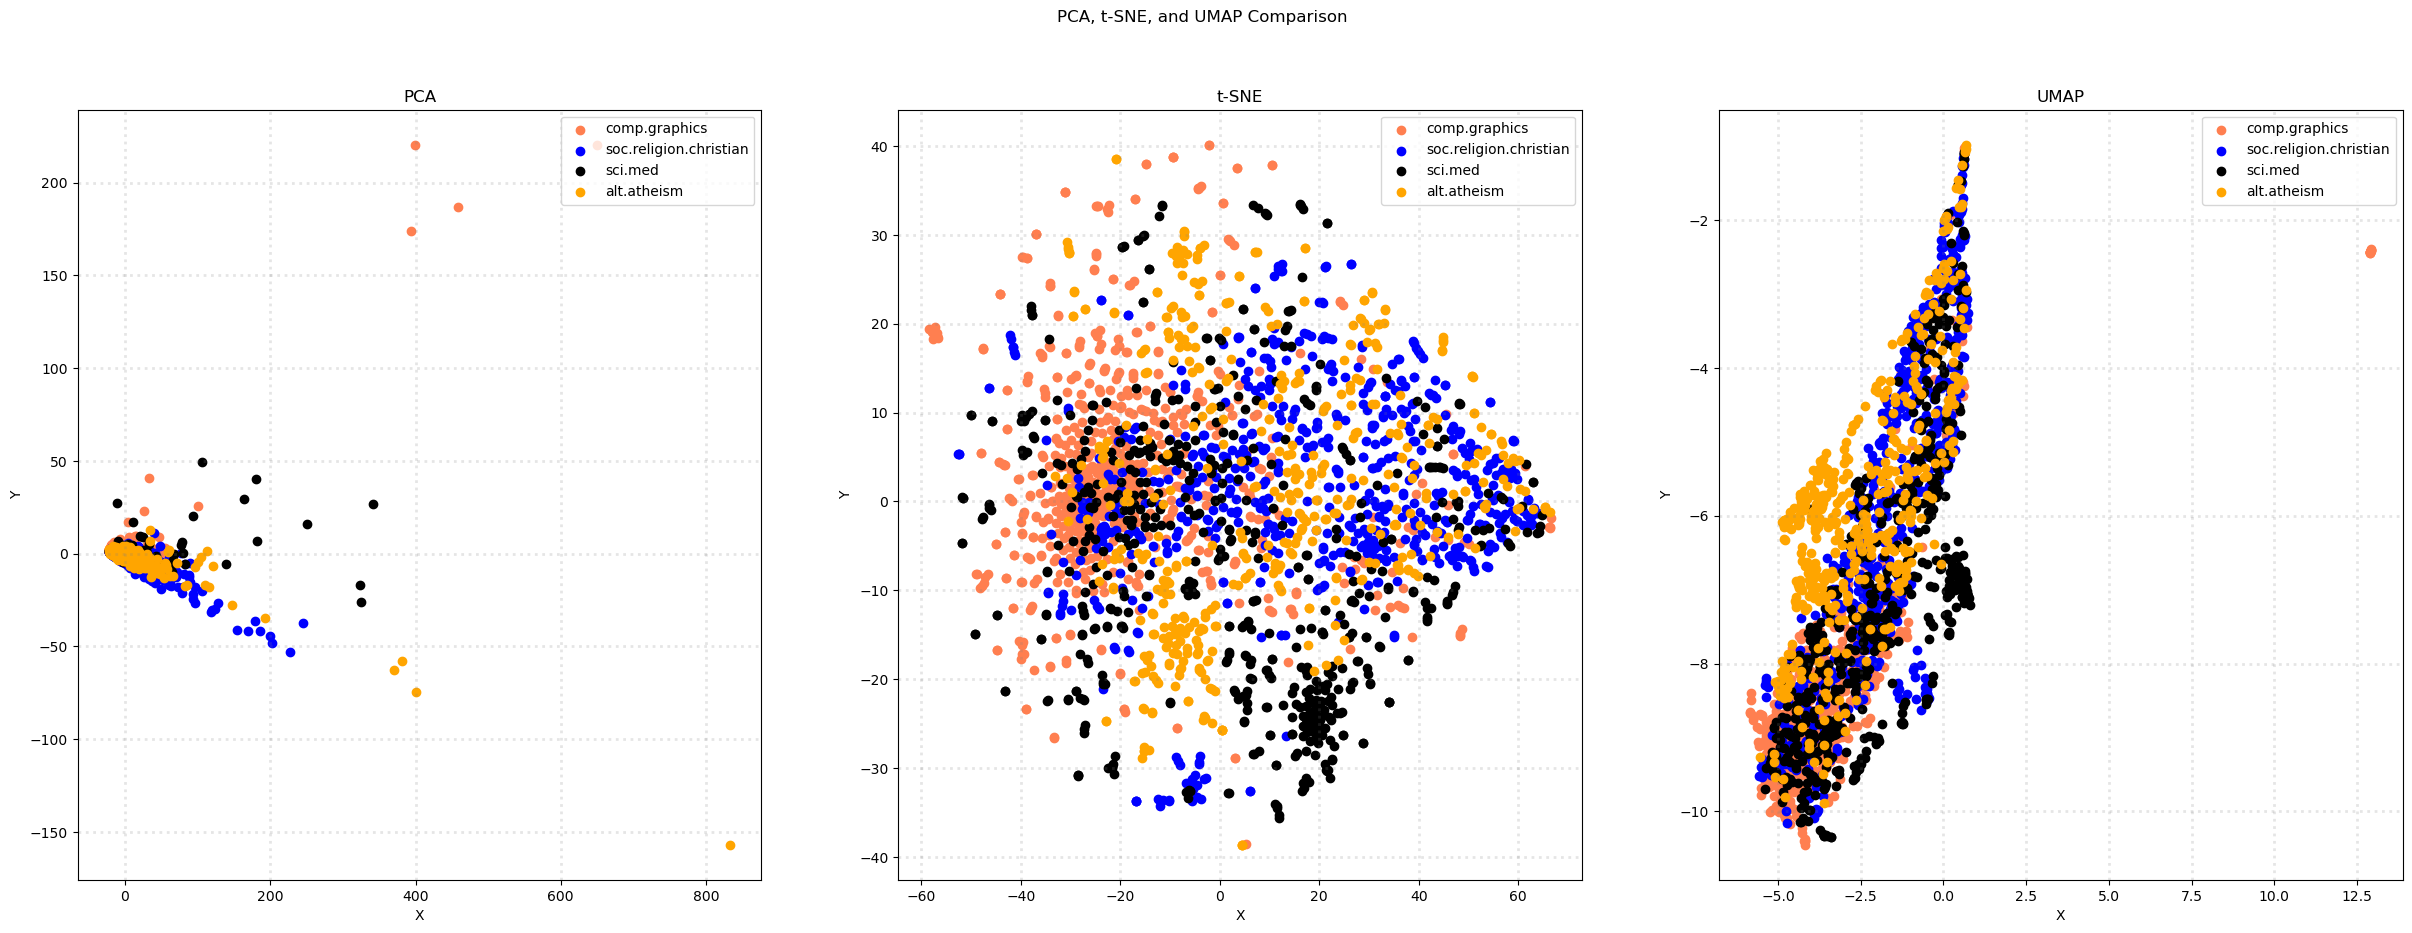

In [122]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique()

fig, axes = plt.subplots(1, 3, figsize=(30, 10)) # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
        
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')


# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_aug, 'PCA')
plot_scatter(axes[1], X_tsne_aug, 't-SNE')
plot_scatter(axes[2], X_umap_aug, 'UMAP')

plt.show()

## Exercise 18 take home

Please try to reduce the dimension to 3, and plot the result use 3-D plot. Use at least 3 different angle (camera position) to check your result and describe what you found.

In [139]:
# reduce dimension to 3
X_umap_tdm_3d = umap.UMAP(n_components=3).fit_transform(tdm_df.values)
X_pca_tdm_3d = PCA(n_components=3).fit_transform(tdm_df.values)
X_tsne_tdm_3d = TSNE(n_components=3).fit_transform(tdm_df.values)

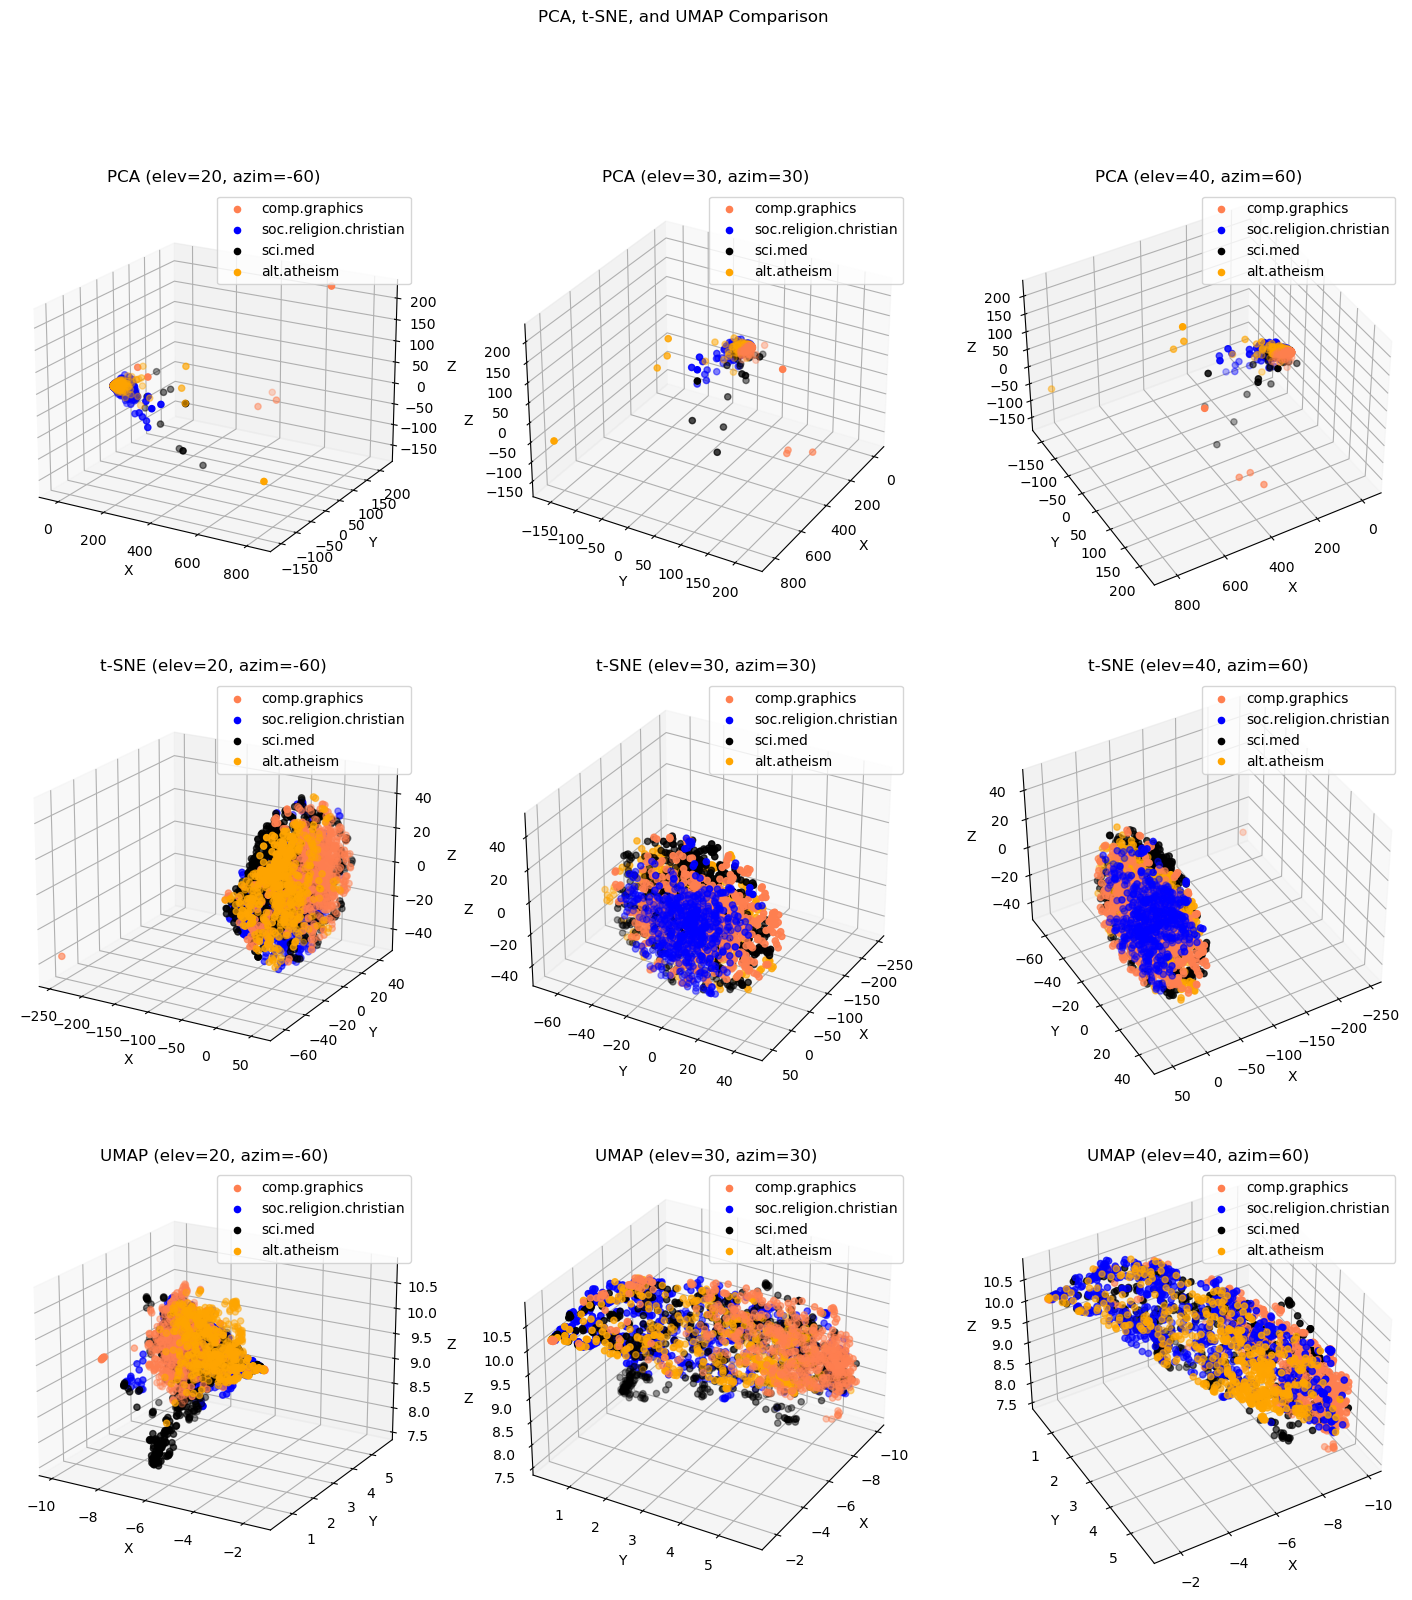

In [147]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 

fig, axes = plt.subplots(3, 3, figsize=(18, 18), subplot_kw={'projection': '3d'})

fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define angles
angles = [(20, -60), (30, 30), (40, 60)]

# Define a function to create a scatter plot for each method
def plot_scatter_3d(ax, X_reduced, title):
    for i, (elev, azim) in enumerate(angles):
        for c, category  in zip(col, categories):
            xs = X_reduced[X['category_name'] == category].T[0]
            ys = X_reduced[X['category_name'] == category].T[1]
            zs = X_reduced[X['category_name'] == category].T[2]
            ax[i].scatter(xs, ys, zs, c=c, marker='o', label=category)
            
            ax[i].view_init(elev=elev, azim=azim)
            ax[i].set_title(f'{title} (elev={elev}, azim={azim})')

        ax[i].grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('Y')
        ax[i].set_zlabel('Z')
        ax[i].legend(loc='best')


# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter_3d(axes[0], X_pca_tdm_3d, 'PCA')
plot_scatter_3d(axes[1], X_tsne_tdm_3d, 't-SNE')
plot_scatter_3d(axes[2], X_umap_tdm_3d, 'UMAP')

plt.show()

## 5.6 Discretization and Binarization

In [123]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(X.category)

LabelBinarizer()

In [124]:
X['bin_category'] = mlb.transform(X['category']).tolist()

In [125]:
X[0:9]

,text,category,category_name,unigrams,tokenized_text,bin_category
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics,"[From, :, sd345, @, city.ac.uk, (, Michael, Co...","{City, We, way, Collier, into, (Programmer), (...","[0, 1, 0, 0]"
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics,"[From, :, ani, @, ms.uky.edu, (, Aniruddha, B....","{Background, appreciated., into, solve., I, be...","[0, 1, 0, 0]"
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian,"[From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...","{comes, I, wiser, for, >me, Your, should, >rea...","[0, 0, 0, 1]"
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian,"[From, :, s0612596, @, let.rug.nl, (, M.M, ., ...","{role, me, Letteren,, the, english,, abortion-...","[0, 0, 0, 1]"
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian,"[From, :, stanly, @, grok11.columbiasc.ncr.com...","{provided., invite, certain, I, at, for, Lines...","[0, 0, 0, 1]"
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian,"[From, :, vbv, @, lor.eeap.cwru.edu, (, Virgil...","{irrelevant, |, convictions., Case, way, >tran...","[0, 0, 0, 1]"
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian,"[From, :, jodfishe, @, silver.ucs.indiana.edu,...","{comes, we, instances., We, Aaron's, Galatians...","[0, 0, 0, 1]"
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med,"[From, :, aldridge, @, netcom.com, (, Jacqueli...","{But, gets, equipment, I, when, Usually, pharm...","[0, 0, 1, 0]"
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med,"[From, :, geb, @, cs.pitt.edu, (, Gordon, Bank...","{|, 2, sensitive, I, now., >blue-yellow., most...","[0, 0, 1, 0]"


## Exercise 19 take home

Try to generate the binarization using the category_name column instead. Does it work?

In [126]:
# Answer here

In [151]:
mlb2 = preprocessing.LabelBinarizer()
mlb2.fit(X.category_name)

X['bin_category'] = mlb2.transform(X['category_name']).tolist()

X.sample(10)

# it work

,text,category,category_name,unigrams,tokenized_text,bin_category
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med,"[From, :, Dan, Wallach, <, dwallach, @, cs.ber...","{Expires:, tensing, directory, issues, howtosi...","[0, 0, 1, 0]"
313,From: ab@nova.cc.purdue.edu (Allen B) Subject:...,1,comp.graphics,"[From, :, ab, @, nova.cc.purdue.edu, (, Allen,...","{compress, long, ""grad, more, I, students"", at...","[0, 1, 0, 0]"
2230,From: news@cbnewsk.att.com Subject: Re: Bible ...,3,soc.religion.christian,"[From, :, news, @, cbnewsk.att.com, Subject, :...","{2, the, Bible, Unsuitable, Subject:, Also, Jo...","[0, 0, 0, 1]"
43,From: zyeh@caspian.usc.edu (zhenghao yeh) Subj...,1,comp.graphics,"[From, :, zyeh, @, caspian.usc.edu, (, zhengha...","{5, offset,, Southern, Under, appreciated., El...","[0, 1, 0, 0]"
1816,From: gt7122b@prism.gatech.edu (boundary) Subj...,3,soc.religion.christian,"[From, :, gt7122b, @, prism.gatech.edu, (, bou...","{paz, Georgia, we, mean, ?Darren, Siemon, But,...","[0, 0, 0, 1]"
1146,From: bil@okcforum.osrhe.edu (Bill Conner) Sub...,0,alt.atheism,"[From, :, bil, @, okcforum.osrhe.edu, (, Bill,...","{mean, bil@okcforum.osrhe.edu, [version, X-New...","[1, 0, 0, 0]"
92,From: bolson@carson.u.washington.edu (Edward B...,1,comp.graphics,"[From, :, bolson, @, carson.u.washington.edu, ...","{way, Gems,, Farin,, I, at, be, bolson@max.bit...","[0, 1, 0, 0]"
252,From: lipman@oasys.dt.navy.mil (Robert Lipman)...,1,comp.graphics,"[From, :, lipman, @, oasys.dt.navy.mil, (, Rob...","{Expires:, |, research,, MD, sent, (Robert, Li...","[0, 1, 0, 0]"
590,From: Lawrence Curcio <lc2b+@andrew.cmu.edu> S...,2,sci.med,"[From, :, Lawrence, Curcio, <, lc2b+, @, andre...","{getting, with, student,, C., Thanks,, Lawrenc...","[0, 0, 1, 0]"
2104,From: reedr@cgsvax.claremont.edu Subject: Re: ...,3,soc.religion.christian,"[From, :, reedr, @, cgsvax.claremont.edu, Subj...","{proof, we, Christian., But, His, corpus,, car...","[0, 0, 0, 1]"


# 6. Data Exploration

In [127]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = X.iloc[50]
random_record_1 = random_record_1['text']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = X.iloc[100]
random_record_2 = random_record_2['text']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = X.iloc[150]
random_record_3 = random_record_3['text']
document_to_transform_3.append(random_record_3)

In [128]:
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

['From: ab@nova.cc.purdue.edu (Allen B) Subject: Re: TIFF: philosophical significance of 42 Organization: Purdue University Lines: 39  In article <prestonm.735400848@cs.man.ac.uk> prestonm@cs.man.ac.uk (Martin   Preston) writes: > Why not use the PD C library for reading/writing TIFF files? It took me a > good 20 minutes to start using them in your own app.  I certainly do use it whenever I have to do TIFF, and it usually works very well.  That\'s not my point.  I\'m >philosophically< opposed to it because of its complexity.  This complexity has led to some programs\' poor TIFF writers making some very bizarre files, other programs\' inability to load TIFF images (though they\'ll save them, of course), and a general inability to interchange images between different environments despite the fact they all think they understand TIFF.  As the saying goes, "It\'s not me I\'m worried about- it\'s all the >other<  assholes out there!"  I\'ve had big trouble with misuse and abuse of TIFF over 

In [129]:
# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [130]:
# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.608862
Cosine Similarity using count bw 1 and 3: 0.622050
Cosine Similarity using count bw 2 and 3: 0.565566
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


# 7. Data Classification

In [131]:
# Create a mapping from numerical labels to category names
category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['category'], test_size=0.3, random_state=42)

In [132]:
X_train

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
X_test

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1513,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.9660766961651918

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.9535    0.9535    0.9535       129
         comp.graphics     0.9540    0.9822    0.9679       169
               sci.med     0.9839    0.9683    0.9760       189
soc.religion.christian     0.9683    0.9581    0.9632       191

              accuracy                         0.9661       678
             macro avg     0.9649    0.9655    0.9651       678
          weighted avg     0.9663    0.9661    0.9661       678



In [135]:
# Create a mapping from numerical labels to category names
category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['category'], test_size=0.3, random_state=42)

In [136]:
X_train

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,soc princeton funds motss matching,soc princeton boy motss matching,et axes motss matching,soc princeton et motss matching,soc princeton al motss matching,axes funds motss matching,boy funds motss matching,boy axes motss matching,et funds motss matching,swell
634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
X_test

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,soc princeton funds motss matching,soc princeton boy motss matching,et axes motss matching,soc princeton et motss matching,soc princeton al motss matching,axes funds motss matching,boy funds motss matching,boy axes motss matching,et funds motss matching,swell
561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1513,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.9734513274336283

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.9837    0.9380    0.9603       129
         comp.graphics     0.9940    0.9822    0.9881       169
               sci.med     0.9789    0.9841    0.9815       189
soc.religion.christian     0.9444    0.9791    0.9614       191

              accuracy                         0.9735       678
             macro avg     0.9753    0.9709    0.9728       678
          weighted avg     0.9739    0.9735    0.9735       678

